In [1]:
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


from mne.decoding import CSP
from mne.channels import read_layout
from loaddata import *
from sklearn import metrics as met
from mne.channels import make_standard_montage

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
fp = {
      'aa' : {
          'cnt': '../DATA/Competencia BCI/III/Dataset_IV/txt/aa/100Hz/data_set_IVa_aa_cnt.txt',
          'mrk': '../DATA/Competencia BCI/III/Dataset_IV/txt/aa/100Hz/data_set_IVa_aa_mrk.txt',
          'lab': '../DATA/Competencia BCI/III/Dataset_IV/txt/aa/TRUE_LABELS.txt',
          'chn': '../DATA/Competencia BCI/III/Dataset_IV/txt/aa/100Hz/ch_names.txt',
          'pos':168,
          'freq': 100
          }
}

low_freq, high_freq = 7., 30.

# event_id
event_id = {'right': 1, 'foot': 2}


In [3]:
sujeto = fp['aa']
#Se carga set de datos crudos
raw = creatRawArray(sujeto)

#Seleccionamos los canales a utilizar
raw.pick_channels(['Fp1', 'Fp2', 'C3', 'C4','P7', 'P8', 'O1', 'O2'])

#Seteamos la ubicacion de los canales segun el 
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)


Creating RawArray with float64 data, n_channels=118, n_times=298458
    Range : 0 ... 298457 =      0.000 ...  2984.570 secs
Ready.


<RawArray | 8 x 298458 (2984.6 s), ~18.2 MB, data loaded>

In [4]:
# Se aplica filtros band-pass
raw.filter(low_freq, high_freq, fir_design='firwin', skip_by_annotation='edge')


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 165 samples (1.650 sec)



<RawArray | 8 x 298458 (2984.6 s), ~18.2 MB, data loaded>

In [5]:
#Se carga eventos
events, labels = creatEventsArray(sujeto)

#Se define tiempo minimo y maximo para los eventos
tmin, tmax = 1., 2.

#Se genera las epocas con los datos crudos y los eventos
epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True,
                verbose=False)

print(epochs)

<Epochs  |   280 events (all good), 1 - 2 sec, baseline off, ~1.8 MB, data loaded,
 'foot': 140
 'right': 140>


In [6]:
#Set de datos train/test
#Lo convierte a matriz numpy
epochs_data = epochs.get_data()

#Se carga target (convierte 1 -> -1 y 2 -> 0 )
target = epochs.events[:, -1] - 2

#Se crea set de de pruebas y test
X_train, X_test, y_train, y_test = train_test_split(epochs_data, target, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)

(196, 8, 101)
(84, 8, 101)


In [7]:
#Clasificadores del modelo LDA
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

#El Modelo utiliza CSP y LDA
clf = Pipeline([('CSP', csp), ('LDA', lda)])

#Entrenamiento del modelo
clf.fit(X_train, y_train)
score = clf.score(X_train, y_train)

#Cross-Validation
scores_val = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=1)

print("Metrica del modelo:", score)
print("Metricas cross_validation:", scores_val)
print("Media de cross_validation:", scores_val.mean())

Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 8 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3 (2.2e-16 eps * 8 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 8 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 8 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: 

In [8]:
from sklearn import svm

#Clasificadores del modelo SVM
lda = LinearDiscriminantAnalysis()
svm = svm.SVC(kernel='linear') # Linear Kernel

#El Modelo utiliza CSP y SVM
clf2 = Pipeline([('CSP', csp), ('SVM', svm)])

#Entrenamiento del modelo
clf2.fit(X_train, y_train)
score = clf2.score(X_train, y_train)

#Cross-Validation
scores_val = cross_val_score(clf2, X_train, y_train, cv=5, n_jobs=1)

print("Metrica del modelo:", score)
print("Metricas cross_validation:", scores_val)
print("Media de cross_validation:", scores_val.mean())

Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 8 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3 (2.2e-16 eps * 8 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 8 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 8 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: 

In [9]:
from sklearn.neighbors import KNeighborsClassifier

#Clasificadores del modelo KNN
lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier(7)

#El Modelo utiliza CSP y KNN
clf3 = Pipeline([('CSP', csp), ('KNN', knn)])

#Entrenamiento del modelo
clf3.fit(X_train, y_train)
score = clf3.score(X_train, y_train)

#Cross-Validation
scores_val = cross_val_score(clf3, X_train, y_train, cv=5, n_jobs=1)

print("Metrica del modelo:", score)
print("Metricas cross_validation:", scores_val)
print("Media de cross_validation:", scores_val.mean())

Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 8 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3 (2.2e-16 eps * 8 dim * 1.7e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.3 (2.2e-16 eps * 8 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 8
    MAG: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.6 (2.2e-16 eps * 8 dim * 1.5e+15  max singular value)
    Estimated rank (mag): 8
    MAG: 

In [10]:
#Resultados
result=clf.predict(X_test)

print( met.confusion_matrix(y_test, result) )
print( "Recall: ", met.recall_score(y_test, result, average=None) )
print( "Precision: ", met.precision_score(y_test, result, average=None) )
print( "F1: ", met.f1_score(y_test, result, average=None) )
print( "Acurracy: ", met.accuracy_score(y_test, result) )

tn, fp, fn, tp = met.confusion_matrix(y_test, result).ravel()
print(tn, fp, fn, tp)

print(met.classification_report(y_test, result))

[[32 21]
 [10 21]]
Recall:  [0.60377358 0.67741935]
Precision:  [0.76190476 0.5       ]
F1:  [0.67368421 0.57534247]
Acurracy:  0.6309523809523809
32 21 10 21
              precision    recall  f1-score   support

          -1       0.76      0.60      0.67        53
           0       0.50      0.68      0.58        31

    accuracy                           0.63        84
   macro avg       0.63      0.64      0.62        84
weighted avg       0.67      0.63      0.64        84



In [11]:
#Resultados
result=clf2.predict(X_test)

print( met.confusion_matrix(y_test, result) )
print( "Recall: ", met.recall_score(y_test, result, average=None) )
print( "Precision: ", met.precision_score(y_test, result, average=None) )
print( "F1: ", met.f1_score(y_test, result, average=None) )
print( "Acurracy: ", met.accuracy_score(y_test, result) )

tn, fp, fn, tp = met.confusion_matrix(y_test, result).ravel()
print(tn, fp, fn, tp)

print(met.classification_report(y_test, result))

[[31 22]
 [10 21]]
Recall:  [0.58490566 0.67741935]
Precision:  [0.75609756 0.48837209]
F1:  [0.65957447 0.56756757]
Acurracy:  0.6190476190476191
31 22 10 21
              precision    recall  f1-score   support

          -1       0.76      0.58      0.66        53
           0       0.49      0.68      0.57        31

    accuracy                           0.62        84
   macro avg       0.62      0.63      0.61        84
weighted avg       0.66      0.62      0.63        84



In [12]:
result=clf3.predict(X_test)

print( met.confusion_matrix(y_test, result) )
print( "Recall: ", met.recall_score(y_test, result, average=None) )
print( "Precision: ", met.precision_score(y_test, result, average=None) )
print( "F1: ", met.f1_score(y_test, result, average=None) )
print( "Acurracy: ", met.accuracy_score(y_test, result) )

tn, fp, fn, tp = met.confusion_matrix(y_test, result).ravel()
print(tn, fp, fn, tp)

print(met.classification_report(y_test, result))

[[30 23]
 [14 17]]
Recall:  [0.56603774 0.5483871 ]
Precision:  [0.68181818 0.425     ]
F1:  [0.6185567  0.47887324]
Acurracy:  0.5595238095238095
30 23 14 17
              precision    recall  f1-score   support

          -1       0.68      0.57      0.62        53
           0       0.42      0.55      0.48        31

    accuracy                           0.56        84
   macro avg       0.55      0.56      0.55        84
weighted avg       0.59      0.56      0.57        84



In [13]:
#print(epochs)
epoch_right = epochs['right']
epoch_foot =epochs['foot']

"""
epoch_right.plot_image(picks=['Fp1'])
epoch_right.plot_image(picks=['Fp2'])
epoch_right.plot_image(picks=['C3'])
epoch_right.plot_image(picks=['C4'])
epoch_right.plot_image(picks=['P7'])
epoch_right.plot_image(picks=['P8'])
epoch_right.plot_image(picks=['O1'])
epoch_right.plot_image(picks=['O2'])

epoch_foot.plot_image(picks=['Fp1'])
epoch_foot.plot_image(picks=['Fp2'])
epoch_foot.plot_image(picks=['C3'])
epoch_foot.plot_image(picks=['C4'])
epoch_foot.plot_image(picks=['P7'])
epoch_foot.plot_image(picks=['P8'])
epoch_foot.plot_image(picks=['O1'])
epoch_foot.plot_image(picks=['O2'])
"""

"\nepoch_right.plot_image(picks=['Fp1'])\nepoch_right.plot_image(picks=['Fp2'])\nepoch_right.plot_image(picks=['C3'])\nepoch_right.plot_image(picks=['C4'])\nepoch_right.plot_image(picks=['P7'])\nepoch_right.plot_image(picks=['P8'])\nepoch_right.plot_image(picks=['O1'])\nepoch_right.plot_image(picks=['O2'])\n\nepoch_foot.plot_image(picks=['Fp1'])\nepoch_foot.plot_image(picks=['Fp2'])\nepoch_foot.plot_image(picks=['C3'])\nepoch_foot.plot_image(picks=['C4'])\nepoch_foot.plot_image(picks=['P7'])\nepoch_foot.plot_image(picks=['P8'])\nepoch_foot.plot_image(picks=['O1'])\nepoch_foot.plot_image(picks=['O2'])\n"

In [14]:
#Estimamos el evoked caracteristico, haciendo promedio del epoch
right_evoked = epoch_right.average()
foot_evoked = epoch_foot.average()

mne.viz.plot_compare_evokeds(dict(right=right_evoked, foot=foot_evoked),
                             legend=True, show_sensors=True)



combining channels using "gfp"
combining channels using "gfp"


<Figure size 800x600 with 2 Axes>

[<Figure size 800x600 with 2 Axes>]

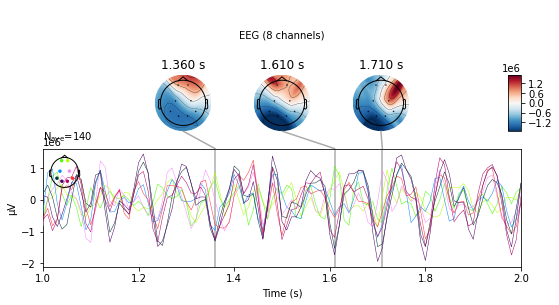

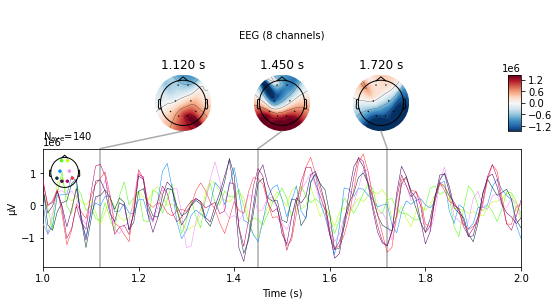

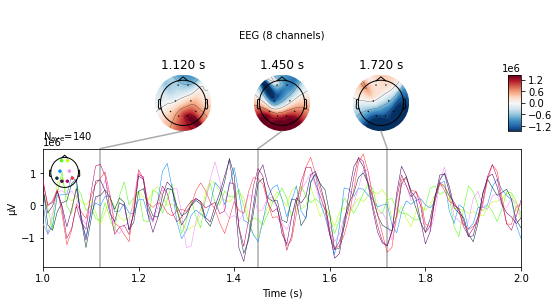

In [15]:
right_evoked.plot_joint()
foot_evoked.plot_joint()
#right_evoked.plot_topomap(times=[1, 1.5, 2])
#foot_evoked.plot_topomap(times=[1, 1.5, 2])